Hello kagglers !!
Today we will handle the basic classification problem. The dataset is derived from (DMA) Denmark Maritime Authority's (open source) AIS information. Our research question is, can we predict the type of ship in a particular region by looking at its characteristics such as width, length, and values such as course and speed? We will analyze the specific part of DMA's data:
Region : Kattegat Strait
Date   : Between 1 January 2022 - 10 March 2022

AIS (Automatic Identification System) technology provides an effective means of tracking ships. The technology is based on Very High Frequency (VHF) broadcasting and carriage of AIS is mandatory for the majority of Safety of Life at Sea (SOLAS) ships greater than 300 gross tonnes. A proportion of other vessels, e.g., fishing and leisure craft, carry it voluntarily due to its usefulness.

First importing the necessary libraries;

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

In [11]:
from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

# FIRST TOUCH TO DATA

At sea all vessels propagate the informations related to herself. This information is divided into two as dynamic and static. Let's have a look at our data;

In [12]:
df = pd.read_csv(r"E:\12.EĞİTİM\bootcamp\kaggle\classification.csv")
df.head()

,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
0,0,219019621,Unknown value,0.0000,86.0000,86.0000,Fishing,4.0000,9.0000,nan
1,1,265628170,Unknown value,0.0000,334.5000,nan,Port tender,8.0000,27.0000,nan
2,2,219005719,Unknown value,0.0000,208.7000,nan,Fishing,4.0000,11.0000,nan
3,3,219028066,Unknown value,0.0000,nan,nan,Pleasure,3.0000,12.0000,nan
4,4,212584000,Moored,0.0000,153.0000,106.0000,Cargo,13.0000,99.0000,6.3000


Static Informations (immutable)
Static Information is provided by the subject vessel's crew and is transmitted every 6 minutes regardless of the vessel's movement status
1   mmsi               : a unique identification number for each vessel station (the vessel's flag can also be deducted from it)
2   shiptype           : ship's type (tanker, cargo, fishing etc)
3   width              : width of vessel
4   length             : length of vessel
5   draught            : draught of vessel (the vertical distance between the waterline and the bottom of the hull (keel))

Dinamic Informations (mutable)
Dinamic Informations automatically transmitted every 2 to 10 seconds depending on the vessel's speed and course while underway and every 6 minutes while anchored from vessels
6   navigationalstatus : instant situation (navigating, mooored etc)
7   sog                : speed of ground
8   cog                : course of ground (0 to 359 degrees)
9   heading            : fore side (heading and cog are not same because of the wind, current. But they are close to each other)


Looking for shape

In [13]:
df.shape

(358351, 10)

Removing the unneeded column

In [14]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [15]:
df.isnull().sum() # we have lots of null values

mmsi                      0
navigationalstatus        0
sog                     458
cog                    3169
heading               20614
shiptype                  0
width                  3711
length                 3743
draught               25543
dtype: int64

# EDA

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358351 entries, 0 to 358350
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   mmsi                358351 non-null  int64  
 1   navigationalstatus  358351 non-null  object 
 2   sog                 357893 non-null  float64
 3   cog                 355182 non-null  float64
 4   heading             337737 non-null  float64
 5   shiptype            358351 non-null  object 
 6   width               354640 non-null  float64
 7   length              354608 non-null  float64
 8   draught             332808 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 24.6+ MB


In [17]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

We have 7 numeric and 2 categorical variables. There is no cardinal variable

In [18]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 358351
Variables: 9
cat_cols: 2
num_cols: 7
cat_but_car: 0
num_but_cat: 0


At sea, every vessel propagates the info regularly. It seems that we have 358351 observations, but our dataset has a fewer vessels number. Let's look;

In [19]:
df.groupby('mmsi').count().shape

(3894, 8)

In [20]:
df['navigationalstatus'].value_counts() # the other important variable which tell us the ship's navigational status

Under way using engine                                   307581
Unknown value                                             17259
Constrained by her draught                                12287
Engaged in fishing                                        10798
Moored                                                     4121
Reserved for future amendment [HSC]                        1872
Restricted maneuverability                                 1868
Under way sailing                                          1396
At anchor                                                   513
Power-driven vessel towing astern                           377
Power-driven vessel pushing ahead or towing alongside       236
Not under command                                            31
Reserved for future amendment [WIG]                          12
Name: navigationalstatus, dtype: int64

Detailed analyze for the missing values; (Number of missing values and the ratio)

In [21]:
def missing_values_table(data):
    m=data.isnull().sum()
    print(pd.DataFrame({'n_miss' : m[m!=0],'ratio' : m[m!=0]/len(data)}))

missing_values_table(df)

         n_miss  ratio
sog         458 0.0013
cog        3169 0.0088
heading   20614 0.0575
width      3711 0.0104
length     3743 0.0104
draught   25543 0.0713


Detailed analyze for the outliers;

In [22]:
def thresholds(col, data, d, u):
    q3=data[col].quantile(u)
    q1=data[col].quantile(d)
    down=q1-(q3-q1)*1.5
    up=q1+(q3-q1)*1.5
    return down, up

def check_outliers(col, data, d=0.25, u=0.75, plot=False):
    down, up = thresholds(col, data, d, u)
    ind = data[(data[col] < down) | (data[col] > up)].index
    if plot:
        sns.boxplot(x=col, data=data)
        plt.show()
    if len(ind)!= 0:
        print(f"\n Number of outliers for '{col}' : {len(ind)}")
        return col

for col in num_cols:
    check_outliers(col, df, 0.01, 0.99)


 Number of outliers for 'mmsi' : 24

 Number of outliers for 'sog' : 2910

 Number of outliers for 'width' : 9

 Number of outliers for 'length' : 47

 Number of outliers for 'draught' : 567


Correlations;

heading  cog     0.9617
length   width   0.9564
dtype: float64


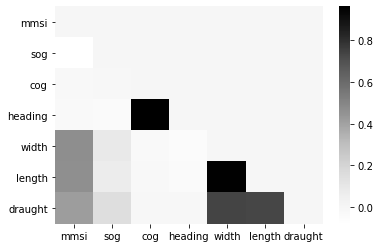

[('heading', 'cog'), ('length', 'width')]

In [23]:
def corr_analyzer(data, corr_th=0.7, plot=False):
    corr_matrix = pd.DataFrame(np.tril(data.corr(), k=-1), columns=data.corr().columns, index=data.corr().columns)
    corr = corr_matrix[corr_matrix>corr_th].stack()
    print(corr)
    if plot: # Görsel olarak analiz
        sns.heatmap(corr_matrix, cmap='Greys')
        plt.show()
    return corr[corr>corr_th].index.tolist()

corr_analyzer(df, corr_th=0.75, plot=True)

# FEATURE ENGINEERING

Actually 'cog' and 'heading' variables are very similar. We can combine these two as a one;

In [24]:
df['route'] = np.where(df['cog'].isnull(), df['heading'], df['cog'])
rot= [-1, 45, 90, 135, 180, 225, 270, 315, 360]
df['waypoint'] = pd.cut(df['route'], rot, labels=['NNE','ENE','ESE','SSE','SSW','WSW','WNW','NNW']) # these are directions
df['waypoint'] = np.where((df['sog']<5.5) & (df['waypoint'].isnull()), 'FIX', df['waypoint']) # for stable vessels

Vessels speed depends on ship type mostly;

In [25]:
df['speed'] = df["sog"].fillna(df.groupby(['shiptype', 'waypoint'])['sog'].transform('mean'))

New aspect for the dimensions;

In [26]:
df['dimension'] = df['width'] * df['length']

We have totally 3894 ships. Let's have a look at the final form of output

In [27]:
df = df.drop_duplicates(subset='mmsi') # one vessel has more than one data
df.groupby(['shiptype'])['mmsi'].count()

shiptype
Cargo               1716
Dredging              53
Fishing              325
HSC                   27
Law enforcement       20
Military              79
Passenger            123
Pilot                 41
Pleasure             414
Port tender           12
Reserved              12
SAR                  123
Sailing              215
Tanker               642
Towing                11
Towing long/wide       3
Tug                   78
Name: mmsi, dtype: int64

In [28]:
df.drop(['cog', 'heading', 'route', 'sog', 'mmsi'], axis=1, inplace=True) # no need anymore

# ENCODING

In [29]:
cat_cols, num_cols, cat_but_car = grab_col_names(df) # taking account for the new variables

Observations: 3894
Variables: 8
cat_cols: 3
num_cols: 5
cat_but_car: 0
num_but_cat: 0


In [30]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col)

                                                    navigationalstatus   Ratio
Under way using engine                                            2587 66.4355
Unknown value                                                      926 23.7802
Moored                                                             130  3.3385
Engaged in fishing                                                 100  2.5681
Constrained by her draught                                          81  2.0801
Restricted maneuverability                                          21  0.5393
At anchor                                                           20  0.5136
Under way sailing                                                   17  0.4366
Reserved for future amendment [HSC]                                  5  0.1284
Not under command                                                    3  0.0770
Power-driven vessel towing astern                                    2  0.0514
Reserved for future amendment [WIG]                 

In our dataset, there are rare values in categorical variables. We will group these classes

In [31]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()
    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]
    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])
    return temp_df

df = rare_encoder(df, 0.02) # Less than %2 ratio will be grouped

In [32]:
df['status'] = df['navigationalstatus'].where(
    ~((df['navigationalstatus']=='Unknown value') | (df['navigationalstatus']=='Rare')), 'Other') # combining two groups

Since we make new variable from 'navigationalstatus', we will disregard this variable. Also if we remember there are high corrrelations between 'dimension', 'width' and 'length'. So we will disregard 'width' and 'length' variables.

In [33]:
df.drop(['navigationalstatus', 'width', 'length'], axis=1, inplace=True)
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 3894
Variables: 6
cat_cols: 3
num_cols: 3
cat_but_car: 0
num_but_cat: 0


Splitting data as an output and predictors;

In [34]:
y = df['shiptype']
X= df.drop('shiptype', axis=1)

One hot encoder process;

In [35]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

X = one_hot_encoder(X, ['waypoint', 'status'])
X.head(3)

,draught,speed,dimension,waypoint_ESE,waypoint_FIX,waypoint_NNE,waypoint_NNW,waypoint_SSE,waypoint_SSW,waypoint_WNW,waypoint_WSW,status_Engaged in fishing,status_Moored,status_Other,status_Under way using engine
0,nan,0.0000,36.0000,0,0,0,0,0,0,0,0,0,0,1,0
1,nan,0.0000,216.0000,0,0,0,1,0,0,0,0,0,0,1,0
2,nan,0.0000,44.0000,0,0,0,0,0,1,0,0,0,0,1,0


The scaling process is an important phase. We will use 'RobustScaler' because it has better results for the outliers

In [36]:
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# MODELING

Since it's quick and accurate, Ligth GBM will be used

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [38]:
lgbm_model = LGBMClassifier(random_state=17) # basic model
lgbm_model

LGBMClassifier(random_state=17)

In [39]:
lgbm_param={'max_depth' : range(2, 20, 2),
            'learning_rate' : np.linspace(0.001, 0.5, 20),
            'n_estimators' : range(200, 2000, 200),
            'colsample_bytree' : np.arange(0.2, 1.1, 0.2)}

lgbm_random = RandomizedSearchCV(estimator=lgbm_model,
                               param_distributions=lgbm_param,
                               n_iter=200,  # number of parameters
                               cv=5,
                               verbose=True,
                               random_state=42,
                               n_jobs=-1)
lgbm_random.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 11.7min finished


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=17), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.2, 0.4, 0.6, 0.8, 1. ]),
                                        'learning_rate': array([0.001     , 0.02726316, 0.05352632, 0.07978947, 0.10605263,
       0.13231579, 0.15857895, 0.18484211, 0.21110526, 0.23736842,
       0.26363158, 0.28989474, 0.31615789, 0.34242105, 0.36868421,
       0.39494737, 0.42121053, 0.44747368, 0.47373684, 0.5       ]),
                                        'max_depth': range(2, 20, 2),
                                        'n_estimators': range(200, 2000, 200)},
                   random_state=42, verbose=True)

In [40]:
lgbm_random.best_params_ # En iyi hiperparametre değerleri

{'n_estimators': 600,
 'max_depth': 2,
 'learning_rate': 0.053526315789473686,
 'colsample_bytree': 0.6000000000000001}

In [41]:
lgbm_random.best_score_  # En iyi skor

0.6954275305166797

In [42]:
lgbm_param={'max_depth' : [4, 5, 6],
            'learning_rate' : [0.007, 0.01, 0.05],
            'n_estimators' : [600, 700, 800],
            'colsample_bytree' : [0.6, 0.7, 0.8]}

lgbm_cv = GridSearchCV(lgbm_model, lgbm_param, cv=10, n_jobs=-1, verbose=True)
lgbm_cv.fit(X, y)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  6.3min finished


GridSearchCV(cv=10, estimator=LGBMClassifier(random_state=17), n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8],
                         'learning_rate': [0.007, 0.01, 0.05],
                         'max_depth': [4, 5, 6],
                         'n_estimators': [600, 700, 800]},
             verbose=True)

In [43]:
lgbm_cv.best_params_ # These are the best parameters for our model

{'colsample_bytree': 0.7,
 'learning_rate': 0.007,
 'max_depth': 6,
 'n_estimators': 800}

In [44]:
lgbm_cv.best_score_  # En iyi skor

0.7000692109946609

In [45]:
lgbm_final = lgbm_model.set_params(**lgbm_cv.best_params_, random_state=17).fit(X_train, y_train)

In [46]:
lgbm_results = cross_val_score(lgbm_final, X_test, y_test, cv=10, scoring="accuracy").mean()
lgbm_results

0.6792366637194224

In [47]:
y_pred = lgbm_final.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Cargo       0.78      0.92      0.84       484
     Fishing       0.67      0.59      0.63        95
    Military       0.52      0.52      0.52        21
   Passenger       0.57      0.40      0.47        40
    Pleasure       0.46      0.74      0.57       129
        Rare       0.56      0.35      0.43        63
         SAR       0.41      0.39      0.40        38
     Sailing       0.44      0.16      0.24        68
      Tanker       0.83      0.55      0.66       206
         Tug       0.61      0.44      0.51        25

    accuracy                           0.68      1169
   macro avg       0.59      0.51      0.53      1169
weighted avg       0.68      0.68      0.67      1169



Our accuracy score is approximitly %68. Actually this accuracy score is nice for multiclass prediction. Let's look detailed;

# PLOT IMPORTANCE

In [48]:
def plot_importance(model, features, num=len(X)):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()

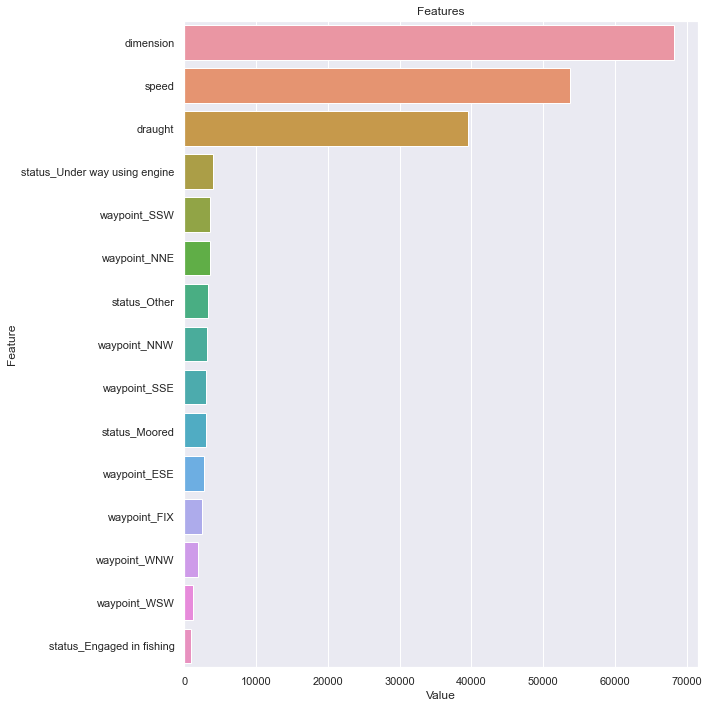

In [49]:
plot_importance(lgbm_final, X_train)

# PREDICTION

In [50]:
def estimator(sample):
   print(f"Our Actual Ship Type \t: {lgbm_final.predict(random_ship)[0]}")
   temp = y.reset_index()
   print(f"Our Predicted Ship Type \t: {temp[temp.index==sample.index[0]].iloc[0,1]}")

In [51]:
random_ship = X.sample(1)
random_ship# this is our one sample to predict

,draught,speed,dimension,waypoint_ESE,waypoint_FIX,waypoint_NNE,waypoint_NNW,waypoint_SSE,waypoint_SSW,waypoint_WNW,waypoint_WSW,status_Engaged in fishing,status_Moored,status_Other,status_Under way using engine
1978,1.7273,0.2222,1.0966,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
